<a href="https://colab.research.google.com/github/Patojukarthikeya73/Infosys_Springboard/blob/main/final_clean_(2).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Backend Development**

Code Input Handling

Accepts Python, JS, or SQL code snippets.
Performs initial sanitization and error detection.
AST Generation

For Python: Uses the built-in ast module.
For JavaScript: Uses esprima via Node.js bridge or Python wrapper.
For SQL: Uses sqlparse to generate a token tree.
Node Traversal

Walks through AST nodes to extract functions, variables, and logical flow.
Converts hierarchical AST to a readable dictionary or JSON.
Syntax Validation

Detects syntax errors or incomplete code.
Returns structured diagnostic messages.
AST Visualization

Tree-view visualization using Streamlit or Graphviz for better understanding.

In [ ]:
!pip install -q transformers gradio torch

import ast
import re
import gradio as gr
from transformers import pipeline

# ---------------- User Management ----------------
users = {}

def register_user(username, password):
    if username in users:
        return False, "⚠️ Username already exists!"
    users[username] = {"password": password}
    return True, "✅ Registration successful! Please login."

def login_user(username, password):
    if username not in users:
        return False, "❌ User not found!"
    if users[username]["password"] != password:
        return False, "🚫 Incorrect password!"
    return True, "✅ Login successful!"

# ---------------- Model Initialization ----------------
phi_model = pipeline("text-generation", model="microsoft/phi-2")
codebert_model = pipeline("text-generation", model="microsoft/codebert-base")

# ---------------- Code Cleaning Helper ----------------
def extract_code_only(text):
    """Removes echoed prompt and retains only the actual code (for Python)."""
    match = re.search(r"(def |class )", text)
    if match:
        return text[match.start():].strip()
    return text.strip()

# ---------------- Python Code Analyzer ----------------
def explain_python_code(code):
    try:
        tree = ast.parse(code)
        explanation = []

        for node in ast.walk(tree):
            if isinstance(node, ast.FunctionDef):
                args = ", ".join(arg.arg for arg in node.args.args)
                explanation.append(f"Defines function '{node.name}' with args: {args}")
            elif isinstance(node, ast.For):
                explanation.append("Includes a for-loop.")
            elif isinstance(node, ast.While):
                explanation.append("Includes a while-loop.")
            elif isinstance(node, ast.If):
                explanation.append("Contains an if-else condition.")
            elif isinstance(node, ast.Assign):
                explanation.append("Performs variable assignment.")

        return " | ".join(set(explanation)) if explanation else "Simple code structure."
    except SyntaxError as e:
        return f"⚠️ Syntax Error in code: {e.msg} (Line {e.lineno})"
    except Exception as e:
        return f"⚠️ Could not analyze code: {str(e)}"

# ---------------- Code Generator ----------------
def generate_code(prompt, language):
    if language == "Python":
        raw_output = phi_model(prompt, max_new_tokens=180)[0]["generated_text"]

        # Remove echoed prompt
        code_candidate = raw_output.replace(prompt, "").strip()

        # Extract only first function or class definition
        match = re.search(r"(def .+?:|class .+?:)", code_candidate)
        if match:
            code = code_candidate[match.start():]
        else:
            code = code_candidate

        # Truncate after two line breaks if too long
        code = code.strip().split("\n\n")[0].strip()

        explanation = explain_python_code(code)
        return code, explanation

    elif language in ["JavaScript", "SQL"]:
        # Only return the first paragraph/block of code
        generated = codebert_model(prompt, max_new_tokens=180)[0]["generated_text"]
        cleaned = generated.replace(prompt, "").strip().split("\n\n")[0]
        return cleaned, f"Generated {language} code using CodeBERT. Review logic manually."

    return "⚠️ Unsupported language selected.", ""


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Device set to use cuda:0
If you want to use `RobertaLMHeadModel` as a standalone, add `is_decoder=True.`
Some weights of RobertaForCausalLM were not initialized from the model checkpoint at microsoft/codebert-base and are newly initialized: ['lm_head.bias', 'lm_head.decoder.bias', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Device set to use cuda:0


**Frontend Development**


Step 1: Code Input & Language Detection
Automatically detects whether the uploaded code is Python, JavaScript, or SQL.
Displays the corresponding analysis mode.

Step 2: AST Parsing (Python)
Uses the AST generated from Module 1.
Extracts functions, variables, loops, and logical flow.
Creates structured summaries for each code block.

Step 3: Model Selection
Language	Model Used
Python	AST-based Rule Engine + GPT fine-tuning
JavaScript	CodeBERT
SQL	CodeBERT + GPT hybrid

Step 4: AI Explanation Generation
CodeBERT and GPT models generate contextual explanations:
What the function or block does
How the logic flows
Possible input/output behavior
Generates concise summaries and insights.

Step 5: Results Display
Displays results in a Streamlit dashboard:
Two-column view for AST (Python) and CodeBERT (JS/SQL) outputs.
Users can compare code structure vs AI interpretation.

In [ ]:
def build_ui():
    with gr.Blocks(title="CodeGenie — Multi-Model Code Generator") as demo:
        gr.Markdown("# 🧠 CodeGenie — Code Generator with Python AST Analysis")

        # ---------- Login/Register Section ----------
        login_section = gr.Group(visible=True)
        with login_section:
            with gr.Tabs():
                with gr.Tab("Register"):
                    reg_user = gr.Textbox(label="Username")
                    reg_pass = gr.Textbox(label="Password", type="password")
                    reg_btn = gr.Button("Register")
                    reg_out = gr.Textbox(label="Status")
                    reg_btn.click(lambda u, p: register_user(u, p)[1], [reg_user, reg_pass], reg_out)

                with gr.Tab("Login"):
                    log_user = gr.Textbox(label="Username")
                    log_pass = gr.Textbox(label="Password", type="password")
                    log_btn = gr.Button("Login")
                    log_out = gr.Textbox(label="Status")

        # ---------- CodeGen Playground ----------
        codegen_section = gr.Group(visible=False)
        with codegen_section:
            gr.Markdown("## 💻 Code Playground")

            lang_select = gr.Radio(["Python", "JavaScript", "SQL"], label="Language", value="Python")
            prompt_input = gr.Textbox(label="🧩 Enter Problem Statement", placeholder="Describe your coding task...")
            gen_btn = gr.Button("🚀 Generate Code")
            code_output = gr.Textbox(label="🧩 Generated Code", lines=12)
            explain_output = gr.Textbox(label="🧠 Code Explanation", lines=6)

            # Button click → trigger backend code generation
            gen_btn.click(generate_code, [prompt_input, lang_select], [code_output, explain_output])

        # ---------- Login Handler ----------
        def handle_login(username, password):
            ok, msg = login_user(username, password)
            if ok:
                return gr.update(visible=False), gr.update(visible=True), msg
            return gr.update(visible=True), gr.update(visible=False), msg

        # Button click → trigger backend login
        log_btn.click(handle_login, [log_user, log_pass], [login_section, codegen_section, log_out])

    return demo

In [ ]:
demo = build_ui()
demo.launch(share=True)

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://a749eae06268428323.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


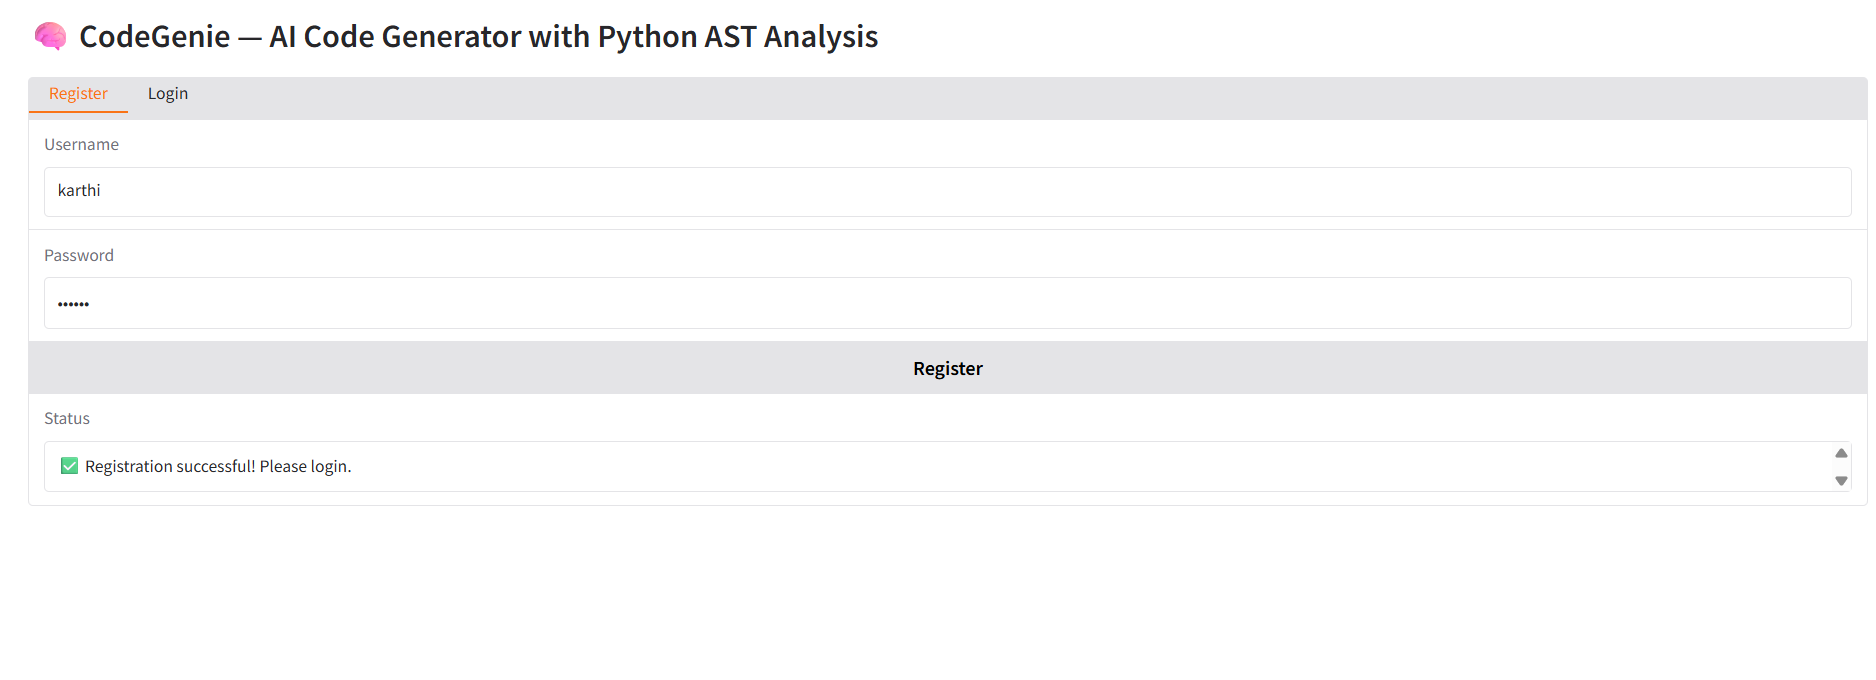

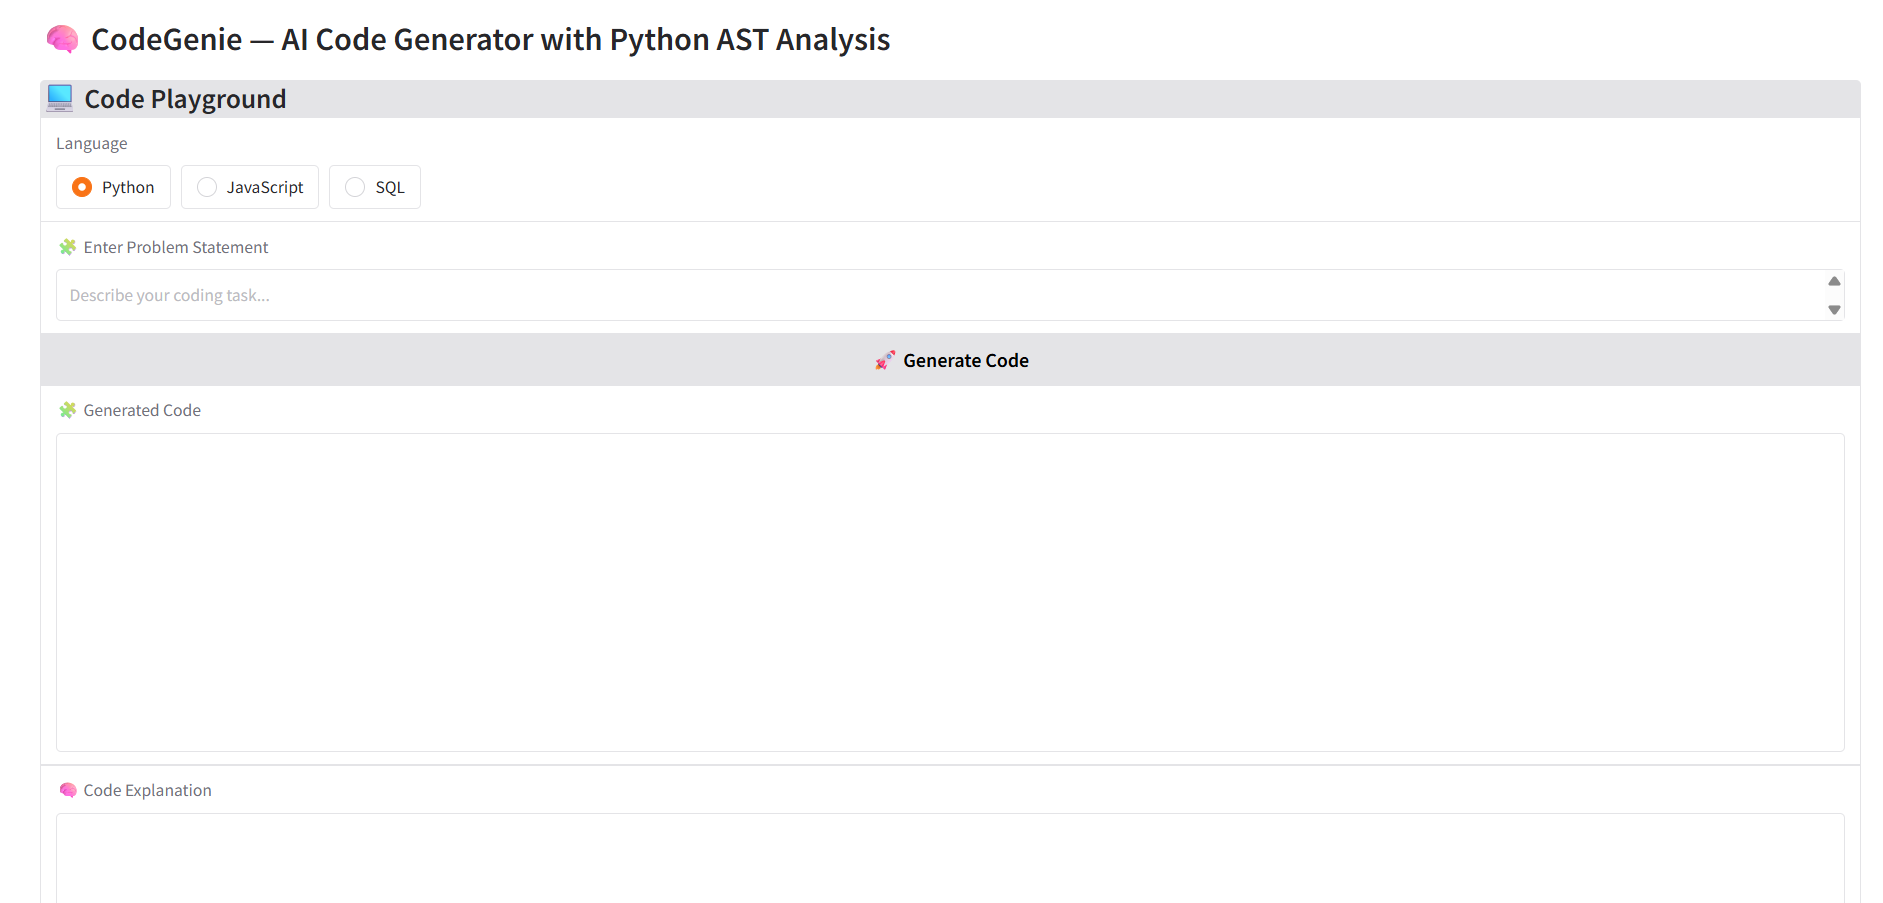